In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel, GPT2Tokenizer
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.io import read_image
from PIL import Image
import random
from transformers import PreTrainedTokenizerFast, AdamW
from transformers import GPT2LMHeadModel
from tqdm import tqdm
import math

### 이미지 전처리를 위한 변환(transformation)을 정의

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # 이미지를 대부분의 사전 훈련 모델에 맞게 크기를 조정
    transforms.ToTensor(),           # 이미지를 PyTorch 텐서로 변환
])

### Flickr8kDataset 클래스를 정의. 클래스는 Flickr8k 이미지 및 캡션 데이터셋을 처리

In [4]:
class Flickr8kDataset(Dataset):
    def __init__(self, annotations_file, img_dir, tokenizer, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_captions = pd.read_csv(annotations_file)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.img_captions) // 5

    def __getitem__(self, idx):
        file_name = self.img_captions.iloc[5 * idx, 0]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        caption = random.choice(self.img_captions.iloc[5 * idx: 5 * (idx + 1), 1].tolist())
        tokenized_caption = self.tokenizer.encode(caption)
        if self.transform:
            image = self.transform(image)
        return image, tokenized_caption

### 데이터셋 및 주요 경로를 설정

In [5]:
img_dir = '/content/drive/MyDrive/Images'
annotations_file = '/content/drive/MyDrive/captions.txt'

tokenizer = GPT2Tokenizer.from_pretrained('gpt2') # GPT-2 토크나이저를 로드

# 데이터셋을 생성하고 학습 및 검증 데이터로 분할
dataset = Flickr8kDataset(annotations_file=annotations_file, img_dir=img_dir, tokenizer=tokenizer, transform=transform)

split_point = int(0.9 * len(dataset))

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [split_point, len(dataset) - split_point])

### 데이터를 묶어서 DataLoader를 생성

In [6]:
def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)

    captions = [[tokenizer.bos_token_id] + cap + [tokenizer.eos_token_id] for cap in captions]

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths), dtype=torch.long)
    masks = torch.zeros(len(captions), max(lengths), dtype=torch.long)

    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.LongTensor(cap)
        masks[i, :end] = 1

    return images, targets, masks

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# CLIP Processor 및 Model, 그리고 GPT-2 토크나이저를 로드
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

### 이미지 캡션 모델을 정의

In [9]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, clip_model, gpt2_model):
        super(ImageCaptioningModel, self).__init__()
        self.clip_model = clip_model
        self.gpt2_model = gpt2_model

        self.proj = nn.Linear(512, gpt2_model.config.hidden_size)

    def forward(self, images, input_ids, attention_mask=None):
        image_features = self.clip_model.get_image_features(pixel_values=images)
        img_features = self.proj(image_features)

        input_embeddings = self.gpt2_model.transformer.wte(input_ids)
        combined_embeddings = input_embeddings + img_features.unsqueeze(1)

        outputs = self.gpt2_model(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=input_ids)
        return outputs

In [10]:
# GPT-2 언어 모델을 로드
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# 이미지 캡션 모델을 생성하고 디바이스로 이동
model = ImageCaptioningModel(clip_model, gpt2_model)
model.to(device)

# 옵티마이저를 설정
optimizer = AdamW(model.parameters(), lr=5e-5)

# 학습 횟수 및 로그 표시 주기를 설정
num_epochs = 10
print_every = 50

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### 학습 루프를 실행

In [11]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    iteration_loss = 0

    num_batches = len(train_dataloader)

    for idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
        batch = tuple(t.to(device) for t in batch)
        images, input_ids, masks = batch

        optimizer.zero_grad()

        outputs = model(images, input_ids=input_ids, attention_mask=masks)
        loss = outputs.loss

        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / num_batches
    print(f"\rEpoch {epoch + 1}/{num_epochs} | Training Loss: {avg_train_loss:.3f}")
    # 검증 데이터로 평가
    model.eval()
    val_loss=0
    with torch.no_grad():
         for batch in val_dataloader:
             batch= tuple(t.to(device) for t in batch)
             images,input_ids,masks=batch
             outputs = model(images, input_ids=input_ids, attention_mask=masks)
             loss=outputs.loss
             val_loss+=loss.item()

         val_loss /= len(val_dataloader)

         print(f"Validation Loss: {val_loss:.3f}")

Epoch 1/10: 100%|██████████| 228/228 [32:42<00:00,  8.61s/it]


Epoch 1/10 | Training Loss: 1.897
Validation Loss: 1.609


Epoch 2/10: 100%|██████████| 228/228 [02:45<00:00,  1.38it/s]


Epoch 2/10 | Training Loss: 1.636
Validation Loss: 1.664


Epoch 3/10: 100%|██████████| 228/228 [02:48<00:00,  1.35it/s]


Epoch 3/10 | Training Loss: 1.573
Validation Loss: 1.554


Epoch 4/10: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s]


Epoch 4/10 | Training Loss: 1.514
Validation Loss: 1.537


Epoch 5/10: 100%|██████████| 228/228 [02:50<00:00,  1.34it/s]


Epoch 5/10 | Training Loss: 1.507
Validation Loss: 1.511


Epoch 6/10: 100%|██████████| 228/228 [02:50<00:00,  1.34it/s]


Epoch 6/10 | Training Loss: 1.486
Validation Loss: 1.466


Epoch 7/10: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s]


Epoch 7/10 | Training Loss: 1.452
Validation Loss: 1.492


Epoch 8/10: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s]


Epoch 8/10 | Training Loss: 1.431
Validation Loss: 1.497


Epoch 9/10: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s]


Epoch 9/10 | Training Loss: 1.416
Validation Loss: 1.446


Epoch 10/10: 100%|██████████| 228/228 [02:51<00:00,  1.33it/s]


Epoch 10/10 | Training Loss: 1.390
Validation Loss: 1.444


### 이미지에 대한 캡션을 생성하는 함수를 정의

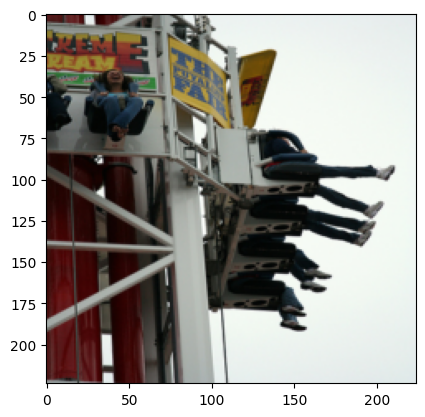

Caption: A man in a blue shirt is jumping off a rock into a pool.


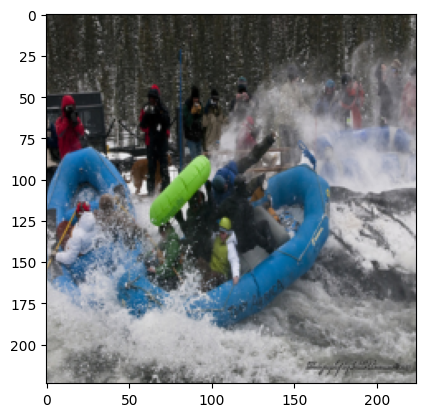

Caption: A man in a blue shirt is standing on a rock with a backpack on his shoulders.


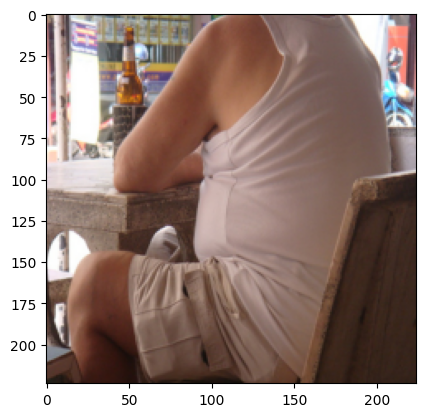

Caption: A man in a blue shirt is holding a baby in his arms.


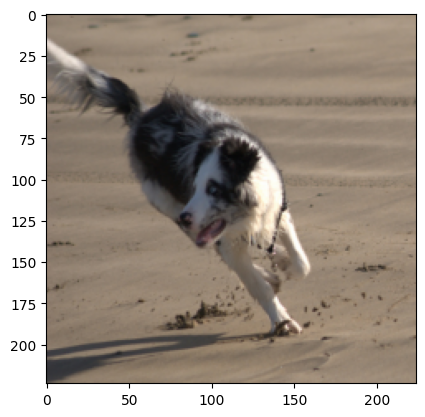

Caption: A dog is running through a field.


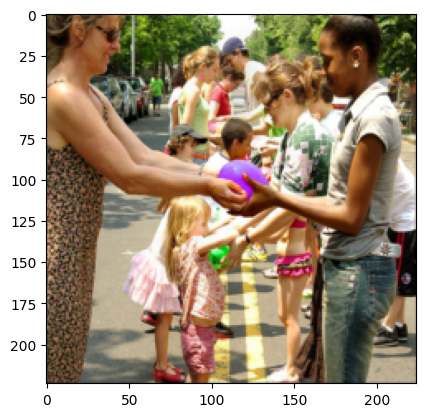

Caption: A group of people are sitting on a bench.


In [12]:
def generate_caption(image, model, tokenizer, max_length=50, temperature=1.0):
    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image.unsqueeze(0), input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i > 1:
                break

    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

def tensor_to_image(tensor):
    # 이미지가 PyTorch Tensor 형식(C x H x W)이고 채널이 RGB라고 가정
    # 이미지를 텐서 형식(0에서 1 사이의 값)에서 matplotlib 형식(0에서 255 사이의 값)으로 정규화
    img = tensor.cpu().numpy().transpose((1,2,0))

    return img

images, _, _ = next(iter(val_dataloader))

images, _, _ = next(iter(val_dataloader))

for i in range(5):
    image = images[i].to(device)

    img = tensor_to_image(image)

    caption = generate_caption(image, model, tokenizer)

    plt.imshow(img)
    plt.show()
    print(f"Caption: {caption}")

이미지에 대한 캡션이 제대로 생성되지 않음.
정확성이 높지않음.
참고했던 캐글(https://www.kaggle.com/code/ndeperrois/resnet-gpt2/notebook)에서도 색을 제대로 인식하지 못했던걸로 보아 성능은 비슷한거 같음.

# 데이터셋에 포함된 데이터가 아닌 구글링해서 받은 사진도 캡셔닝 진행

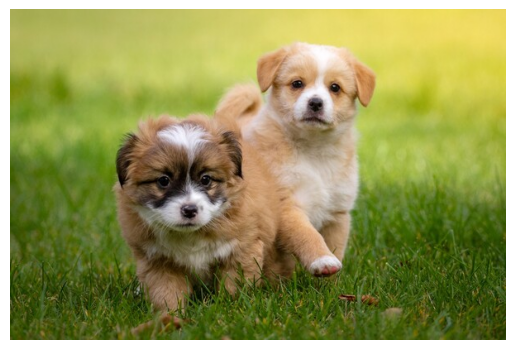

Caption: A dog is running through a grassy field.


In [14]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption_from_file(image_path, model, tokenizer, max_length=50, temperature=1.0):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image, input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i > 1:
                break

    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

image_path = "/content/drive/MyDrive/dog.jpg"  # Replace with the path to your own image file
image_caption = generate_caption_from_file(image_path, model, tokenizer)

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Caption: {image_caption}")


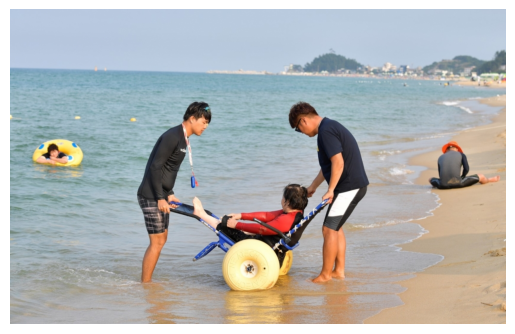

Caption: A man in a blue shirt is jumping into the air.


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption_from_file(image_path, model, tokenizer, max_length=50, temperature=1.0):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image, input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i > 1:
                break

    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

image_path = "/content/beach.jpg"  # Replace with the path to your own image file
image_caption = generate_caption_from_file(image_path, model, tokenizer)

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Caption: {image_caption}")


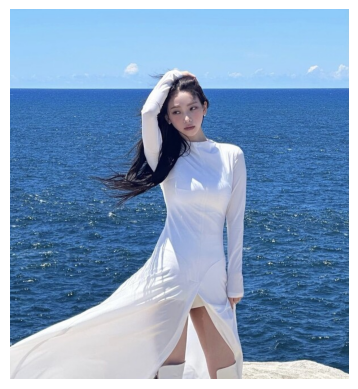

Caption: A boy in a blue shirt is jumping into a pool.


In [16]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption_from_file(image_path, model, tokenizer, max_length=50, temperature=1.0):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image, input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i > 1:
                break

    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

image_path = "/content/karina.jpg"  # Replace with the path to your own image file
image_caption = generate_caption_from_file(image_path, model, tokenizer)

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Caption: {image_caption}")


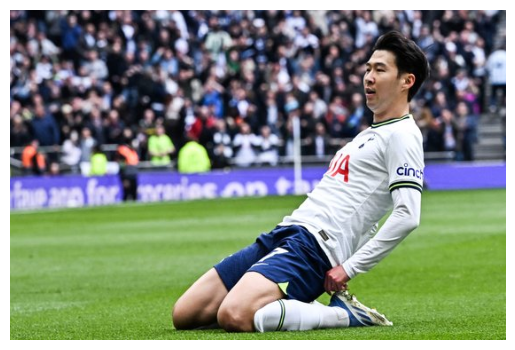

Caption: A football player in a red uniform is running with the ball.


In [17]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption_from_file(image_path, model, tokenizer, max_length=50, temperature=1.0):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)

    caption = [tokenizer.bos_token_id]

    model.eval()

    with torch.no_grad():
        for i in range(max_length):
            input_ids = torch.LongTensor(caption).unsqueeze(0)
            input_ids = input_ids.to(device)
            outputs = model(image, input_ids)

            logits = outputs.logits[:, -1, :] / temperature
            predicted_id = logits.argmax(1).item()
            caption.append(predicted_id)

            if predicted_id == tokenizer.eos_token_id and i > 1:
                break

    generated_caption = tokenizer.decode(caption, skip_special_tokens=True)
    return generated_caption

image_path = "/content/son.jpg"  # Replace with the path to your own image file
image_caption = generate_caption_from_file(image_path, model, tokenizer)

# Load and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

print(f"Caption: {image_caption}")